<a href="https://colab.research.google.com/github/jhu-nanoenergy/VAE-models/blob/main/AE_framework_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Helpful tutorial / example links
# https://github.com/timbmg/VAE-CVAE-MNIST/blob/master/models.py
# https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

In [2]:
import matplotlib.pyplot as plt
import scipy.io as spio
import scipy.stats as stat
import pandas as pd
import numpy as np
import os
import random

os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #leftover from debugging but generally useful to have for cuda device side assert errors

import torch
import torchvision
import torch.optim as optim
import argparse
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.utils.checkpoint import checkpoint 
import h5py

import gc

from torch import autograd

!pip install -q -U torchinfo
from torchinfo import summary

plt.style.use('ggplot')

In [3]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)


Mounted at /content/drive/


# Model Setup and Data Preparation

In [4]:
# # DEFINE HYPERPARAMETERS # #

# for defining data
half_data_num = 500 # amount of data to use from EACH int / ext dataset
bsize = 6 # batch size, careful about making bigger because can cause cuda error 


# for defining network
fv = [256, 256, 512, 1024, 2048] #Channels/Convolutions of Images
fv_inv = [1024, 512, 256] #Channels/Tranpose Convolutions of Latent Space
ks = 3 #kernel size
feat_size = 512 #Feature Space Size
latent_features = 20 # dimensionality of latent space

# for defining loss
alpha = 2 #how much to weight MSE loss

# for defining training 
epochs = 10 # number of epochs to train for
lr = 1e-6 # learning rate of SGD optimizer
w_d = 1e-5 # weight decay of SGD optimizer

In [5]:
# Get the wavelengths data from drive to use in the spectra plots at the end

int_data_all = spio.loadmat('/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/int_total_sqr_no_struct.mat', squeeze_me=True)
# ext_data_all = spio.loadmat('/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/ext_total_sqr_no_struct.mat', squeeze_me=True)
wavelengths = int_data_all['lambda']
wavelengths = np.delete(wavelengths,np.where(wavelengths==[0.5]))
wavelengths = np.delete(wavelengths,np.where(wavelengths==[1]))
wavelengths = np.transpose(np.tile(wavelengths,(3,1)))

spec_points = 219 # number of points in the spectra
# print(np.shape(wavelengths))

In [6]:
# import data from hdf file
fname_mask = '/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/allData.h5'
hdf_file = h5py.File(fname_mask, "r")

# # Print statements for investigating data parameters
# print(list(hdf_file.keys()))
# dext_spectra = hdf_file['ext/maskCell']
# dint_spectra = hdf_file['int/maskCell']
# combined = np.concatenate((dext_spectra[:11],dint_spectra[:11]), axis=0)
# print(np.shape(combined))

In [7]:
class ImageDataset(Dataset):
  #hf is the hdf5 file object
  #datanum is the number of datapoints from EACH set that will be used in the model
    def __init__(self,  hf, datanum, transform= transforms.Compose([ transforms.ToTensor(), transforms.ConvertImageDtype(dtype=torch.float)])  ):
        super(Dataset, self).__init__()
        dext_height = hf['ext/height'] # height values of ext data
        dint_height = hf['int/height'] # height values of int data
        dext_spectra = hf['ext/spectCell'] # spectra values of ext data
        dint_spectra = hf['int/spectCell'] # spectra values of int data

        # get data into correct format
        self.spectra = torch.from_numpy(np.concatenate((dext_spectra[:datanum], dint_spectra[:datanum]), axis=0)) # spectra
        self.heights = torch.from_numpy(np.concatenate((dext_height[:datanum],dint_height[:datanum]), axis=0)) # heights
        self.masks = np.concatenate((hf['ext/maskCell'][:datanum],hf['int/maskCell'][:datanum]), axis=0)  # masks
        self.sizes =  torch.from_numpy(np.concatenate((hf['ext/size'][:datanum],hf['int/size'][:datanum]), axis=0)) # could switch to sreyas size calculation instead, not sure
        ext_label = np.ones((np.shape(dext_height))) # 1 label for ext data
        int_label = np.zeros((np.shape(dint_height))) # 0 label for ext data
        self.labels = torch.from_numpy(np.concatenate( (ext_label, int_label), axis=0)) # combine labels
        self.transform = transform             

    def __len__(self):
        return len(self.sizes)

    # currently extracting image, spectra and height 
    def __getitem__(self, idx): 
        image = (self.masks[idx,:,:]) # input mask image
        spectra = (( self.spectra[idx] )) # spectra  
        if self.transform: 
            image = self.transform(image) 
        return image, spectra

In [9]:
# # Data preparation

# TO DO:
# DEFINE RANDOM SEED FOR DATA SET

full_dataset = ImageDataset(hdf_file, half_data_num )

# Define ratios of train, validation and testing data
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = int(0.1 * len(full_dataset))

# Use random split to split up the data
data_temp, data_test = torch.utils.data.random_split(full_dataset, [train_size+val_size, test_size])
data_train, data_val = torch.utils.data.random_split(data_temp, [train_size, val_size])

# Split data into random batches
train_dataloader = DataLoader(data_train, batch_size = bsize, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size = bsize)
valid_dataloader = DataLoader(data_val, batch_size = bsize)

# clear some unnecessary variables
del hdf_file, int_data_all, data_temp
gc.collect()

102



```
 
```

# "Encoder" (combined Feature Extraction Network, Prediction Network and Recognition Network)

In [12]:
from re import X
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()

    # Feature Extraction Network
    self.enc1 = nn.Sequential( # Feature Extraction Network extraction_layers
            # Conv_1
            nn.Conv2d(1, fv[0], kernel_size=ks, stride=1, padding="same"),
            nn.BatchNorm2d(fv[0]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            
            # Conv_2 + Pool_1
            nn.Conv2d(fv[0], fv[1], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[1]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),     
            nn.MaxPool2d(2,2),

            # Conv_3 + Pool_2
            nn.Conv2d(fv[1], fv[2], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[2]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(2,2),

            # Conv_4 + Pool_3
            nn.Conv2d(fv[2], fv[3], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[3]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(2,2),
        )
    self.enc2 = nn.Sequential( # feature_layer of Feature Extraction Network
            nn.Linear(32*32*1024, feat_size), #reducing to feat_size
            nn.BatchNorm2d(1)
        )

    # # Prediction network
    self.pred1 = nn.Sequential( 
            nn.Linear(feat_size, feat_size),
            nn.BatchNorm2d(1),
            nn.Linear(feat_size, feat_size),
            nn.BatchNorm2d(1),
            nn.Linear(feat_size, spec_points*3)
        )


    # # Recognition network
    self.rec1 =  nn.Sequential( nn.Linear(feat_size+3*spec_points, feat_size),
                               nn.BatchNorm2d(1),
    )
    self.fc_mean = nn.Linear(feat_size, latent_features)
    self.fc_cov = nn.Linear(feat_size, latent_features)
    
  def forward(self, x):

    # # Run Feature Extraction Network
    # encoding
    # batch size usually equals int(torch.numel(x)/256/256), but the final batch in loader may be less than batch size
    x = (x.view(int(torch.numel(x)/256/256), 1, 256, 256)) # get x in format of 4D tensor for inputting into Conv layers 
    x = self.enc1(x)

    # get e in format of 4D tensor for inputting into Linear layer 
    e = x.view(int(torch.numel(x)/32/32/1024), 32*32*1024)     
    e = torch.unsqueeze(e,1)
    e = torch.unsqueeze(e,1)    
    e = self.enc2(e) # run linear layer

    # # Run Prediction Network
    p = torch.sigmoid(self.pred1(e)) # p = predicted spectra

    # # Run Recognition Network
    input_rec = torch.cat((e,p), 3) # Combine condensed geometry features with the predicted spectra    
    x = self.rec1(input_rec)
    mu = self.fc_mean(x)
    log_var = self.fc_cov(x)

    return p, mu, log_var 

# "Decoder" (Regeneration Network)

In [13]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.recog = nn.Sequential(
          #Fc_4 Fc_5 Fc_6
          nn.Linear(latent_features+3*spec_points, feat_size),
          nn.BatchNorm2d(1),
          nn.Linear(feat_size, feat_size),
          nn.BatchNorm2d(1),
          nn.Linear(feat_size, 32*32*fv_inv[0]),
          nn.BatchNorm2d(1),
        )

    self.reconstruct = nn.Sequential(
          nn.ConvTranspose2d(fv_inv[0], fv_inv[1], 3, stride=2, padding = 1, output_padding=1),
          nn.ConvTranspose2d(fv_inv[1], fv_inv[2], 3, stride=2, padding = 1, output_padding=1),
          nn.ConvTranspose2d(fv_inv[2], 1, 3, stride=2, padding = 1, output_padding=1)
        )


  def forward(self, spectra,latent):
    input_dec = torch.cat((spectra,latent),3) # combine spectra output with latent space output
    x = self.recog(input_dec) # run recognition layer
    x = x.view(int(torch.numel(x)/32/32/fv_inv[0]), fv_inv[0], 32, 32) # ensure the 4D tensor is the correct size
    x = self.reconstruct(x) # run reconstruction layer
    reconstruction =  torch.sigmoid( x )
    return reconstruction # output geometry based on spectra and latent space

# VAE Model Definition (includes reparameterization)

In [14]:
# primary VAE module

class CustomVAE(nn.Module):
    def __init__(self):
        super(CustomVAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def forward(self, x):      
        x = self.encoder(x)  
        spectra, mu, log_var  = x        

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        recon_x = self.decoder( spectra, z )
        recon_x = recon_x.view(int(torch.numel(recon_x)/256/256), 256, 256) # reconstructed geometry
        return recon_x, mu, log_var, spectra

    # TO DO: DEFINE SPECTRA PREDICTION FUNCTION AND GEOMETRY GENERATION


# Training and Validation Function Definitions

In [15]:
# combined loss function that determines the entire network
def final_loss(loss1_bce, loss2_mse, mu, logvar):
    """
    This function will add the reconstruction loss and the  KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    
    
    # KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # previous KLD definition
    KLD = 0
    # print(KLD)
    return (loss1_bce + alpha*loss2_mse + KLD)

    # TO DO: determine whether KLD is still going to NAN or not


In [16]:
# fit function for training the model
def fit(model, dataloader):
    model.train() 
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_dataloader)/dataloader.batch_size)):
      if torch.cuda.is_available():
        # with autograd.detect_anomaly(): # uncomment this to debug when you receive "Cuda: device-side assert error"  
          
          data, spectra_in = [d.cuda( ) for d in data] # load in data from data loader
          data = data.view(int(torch.numel(data)/256/256),  256, 256) # resize data for loss function later
          optimizer.zero_grad() # initialize gradients to zero

          reconstruction, mu, logvar, out_spectra = model(data) # run model
          pout = out_spectra.view(-1, 3, spec_points)  # reformat spectra for plotting
          
          # leftover code from when i was trying to debug NAN error, potentially unnecessary
          reconstruction = reconstruction.clamp(0,1) # clamp between 0 and 1
          reconstruction[reconstruction!=reconstruction] = 1 # set NAN values  

          # solve for loss
          bce_loss = criterion_mask(reconstruction, data)          
          mse_loss = criterion(spectra_in.float(), pout)          
          loss = final_loss(bce_loss, mse_loss, mu, logvar)
          running_loss += loss.item()          

          # backpropagate loss and then step the optimizer
          loss.backward()
          optimizer.step()

    train_loss = running_loss/len(dataloader.dataset)
    return train_loss
    


In [17]:
# validate function for testing the model on the validation data

def validate(model, dataloader, plot_on):
  model.eval()
  running_loss = 0.0
  with torch.no_grad(): # all gradients off because currently just evaluating the model
    for i, data in tqdm(enumerate(dataloader), total=int(len(valid_dataloader)/dataloader.batch_size)):
        data, spectra_in = [d.cuda( ) for d in data] # load in data from data loader
        len_temp = int(torch.numel(data)/256/256) # usually this is batch size, but sometimes last batch is a different size
        data = data.view(len_temp,  256, 256) # resize data for loss function later

        reconstruction, mu, logvar, out_spectra = model(data) # run model
        pout = out_spectra.view(-1, 3, spec_points) #reformat spectra for plotting

        # leftover code from when i was trying to debug NAN error, potentially unnecessary
        reconstruction = reconstruction.clamp(0,1) # clamp between 0 and 1
        reconstruction[reconstruction!=reconstruction] = 1 # set NAN values  
        
        # solve for loss
        bce_loss = criterion_mask(reconstruction, data)
        mse_loss = criterion(spectra_in.float(), pout)
        loss = final_loss(bce_loss, mse_loss, mu, logvar)
        running_loss += loss.item()

        # save and plot the last batch input and output 
        if plot_on:
          if i == len_temp - 1:
            print("MSE loss: " + str(mse_loss)) # spectra prediction loss

            # first plot shows input geometry vs output geometry
            num_replicas = 4
            fig, axs = plt.subplots(2,num_replicas)
            for x in range( num_replicas ):      
              axs[0,x].imshow(torch.squeeze(data.view(len_temp, 1, 256, 256)[x]).cpu())
              axs[0,x].xaxis.set_visible(False)
              axs[0,x].yaxis.set_visible(False)
              axs[1,x].imshow(torch.squeeze(reconstruction.view(len_temp, 1, 256, 256)[x]).cpu())
              axs[1,x].xaxis.set_visible(False)
              axs[1,x].yaxis.set_visible(False)
            fig.suptitle(str(epoch+1))

            # second plot shows input spectra vs output spectra
            og = spectra_in[0].detach().cpu().numpy()
            pred = pout[0].detach().cpu().numpy()
            
            fig2, axs = plt.subplots(2,1)
            axs[0].plot(wavelengths, np.transpose(og) )
            axs[1].plot(wavelengths, np.transpose(pred) )
            fig2.suptitle(str(epoch+1))

            # save figures
            fig.savefig(f"/content/drive/MyDrive/Thon Group Master Folder/Serene/Spectral Selectivity Project/outputs/{epoch+1}geom_output.png")
            fig2.savefig(f"/content/drive/MyDrive/Thon Group Master Folder/Serene/Spectral Selectivity Project/outputs/{epoch+1}spectra_output.png")
            plt.show()
            
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

# Model Training Implementation

In [18]:

model_custom = CustomVAE().cuda() # send model architecture to cuda
print(summary(model_custom, input_size = (bsize,1,256,256))) # print model summary
optimizer = optim.SGD(model_custom.parameters(), lr=lr, weight_decay = w_d) #use SGD optimizer to mimic paper
criterion_mask = nn.BCELoss(reduction='sum') # use BCE loss for mask / geometry criterion
criterion = nn.MSELoss() # use MSE loss for spectra criterion

Layer (type:depth-idx)                   Output Shape              Param #
CustomVAE                                --                        --
├─Encoder: 1-1                           [6, 1, 1, 657]            --
│    └─Sequential: 2-1                   [6, 1024, 32, 32]         --
│    │    └─Conv2d: 3-1                  [6, 256, 256, 256]        2,560
│    │    └─BatchNorm2d: 3-2             [6, 256, 256, 256]        512
│    │    └─LeakyReLU: 3-3               [6, 256, 256, 256]        --
│    │    └─Conv2d: 3-4                  [6, 256, 256, 256]        590,080
│    │    └─BatchNorm2d: 3-5             [6, 256, 256, 256]        512
│    │    └─LeakyReLU: 3-6               [6, 256, 256, 256]        --
│    │    └─MaxPool2d: 3-7               [6, 256, 128, 128]        --
│    │    └─Conv2d: 3-8                  [6, 512, 128, 128]        1,180,160
│    │    └─BatchNorm2d: 3-9             [6, 512, 128, 128]        1,024
│    │    └─LeakyReLU: 3-10              [6, 512, 128, 128]      

In [19]:
# check that cuda is at acceptable limits
torch.cuda.synchronize()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    4155 MB |    4931 MB |    7036 MB |    2881 MB |
|       from large pool |    4152 MB |    4927 MB |    7033 MB |    2881 MB |
|       from small pool |       3 MB |       3 MB |       3 MB |       0 MB |
|---------------------------------------------------------------------------|
| Active memory         |    4155 MB |    4931 MB |    7036 MB |    2881 MB |
|       from large pool |    4152 MB |    4927 MB |    7033 MB |

Epoch 1 of 10


117it [00:34,  3.42it/s]
100%|██████████| 5/5 [00:00<00:00,  9.60it/s]

MSE loss: tensor(0.1789, device='cuda:0')


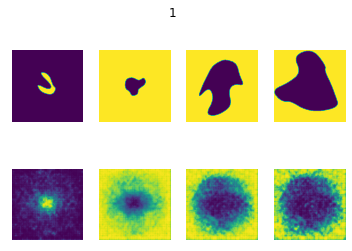

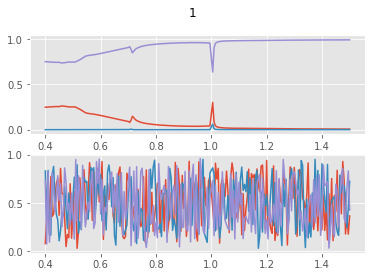

34it [00:06,  5.39it/s]


Train Loss: 26056.4417
Val Loss: 17622.7144
Epoch 2 of 10


117it [00:33,  3.45it/s]
34it [00:03,  9.82it/s]


Train Loss: 15884.5771
Val Loss: 12119.0820
Epoch 3 of 10


117it [00:34,  3.44it/s]
34it [00:03,  9.76it/s]


Train Loss: 13889.9012
Val Loss: 12384.0161
Epoch 4 of 10


117it [00:34,  3.44it/s]
34it [00:03,  9.78it/s]


Train Loss: 13212.3518
Val Loss: 11845.1393
Epoch 5 of 10


117it [00:34,  3.44it/s]
100%|██████████| 5/5 [00:00<00:00,  9.65it/s]

MSE loss: tensor(0.1818, device='cuda:0')


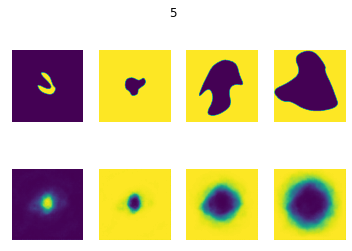

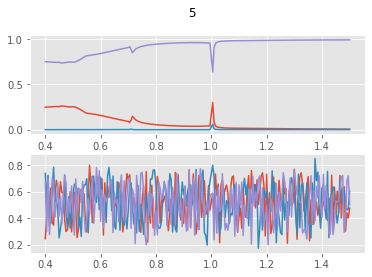

34it [00:04,  7.04it/s]


Train Loss: 13051.3907
Val Loss: 13557.1012
Epoch 6 of 10


117it [00:34,  3.44it/s]
34it [00:03,  9.79it/s]


Train Loss: 12895.0600
Val Loss: 11978.7157
Epoch 7 of 10


117it [00:34,  3.44it/s]
34it [00:03,  9.84it/s]


Train Loss: 12862.9575
Val Loss: 11587.0070
Epoch 8 of 10


117it [00:33,  3.44it/s]
34it [00:03,  9.84it/s]


Train Loss: 12691.1740
Val Loss: 12169.5473
Epoch 9 of 10


117it [00:33,  3.44it/s]
34it [00:03,  9.83it/s]


Train Loss: 12115.4809
Val Loss: 9922.2633
Epoch 10 of 10


117it [00:34,  3.43it/s]
100%|██████████| 5/5 [00:00<00:00,  9.58it/s]

MSE loss: tensor(0.2082, device='cuda:0')


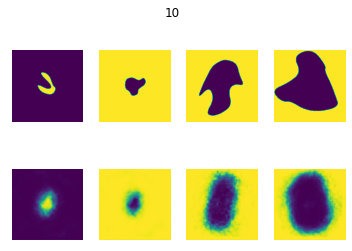

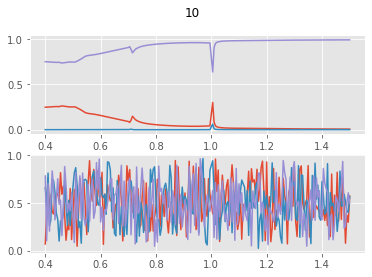

34it [00:04,  7.04it/s]

Train Loss: 10593.0067
Val Loss: 8945.6979


In [20]:
# Loop over epochs 
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    # empty cuda cache to help prevent unneeded memory usage
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    
    # fit data
    train_epoch_loss = fit(model_custom, train_dataloader) 

    # test on validation data
    if epoch == 0 or not ((epoch+1) % 5): # plot output every 5 epochs
      val_epoch_loss = validate(model_custom, valid_dataloader, 1)
    else: # determine validation loss without plotting
      val_epoch_loss = validate(model_custom, valid_dataloader, 0)
    
    # add to variables
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

    # print progress
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

In [21]:
# print post summary of GPU usage
!nvidia-smi

Fri Mar 18 00:14:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    56W / 300W |  14933MiB / 16160MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------